In [1]:
import os
from os.path import abspath, dirname
import shutil as sh
from io import StringIO
from icecream import ic
import fitz

from PIL import Image
from matplotlib import pyplot as plt 
import pytesseract
import numpy as np
import cv2
import pandas as pd
from collections import defaultdict

## Bar chart

### No image preprocessing

In [2]:
filename = '/Users/schnappiiii/juypter_notebook/Bundesbank/Data_report/manual_label/chart_type/single-legend vertical bar chart/hellenicbank_2020_en_P34_Nr.4_class_0.png'
img1 = np.array(Image.open(filename))

# Get verbose data including boxes, confidences, line and page numbers
data = pytesseract.image_to_data(Image.open(filename))

df = pd.read_csv(StringIO(data), sep='\t')
df = df.dropna().reset_index().drop(labels='index', axis=1)
df = df[~df['text'].isin([' ','  ','   '])]
df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,5,1,1,1,1,1,27,4,196,23,96.669960,REDUCTION
1,5,1,1,1,1,2,237,4,31,22,96.415703,IN
2,5,1,1,1,1,3,280,4,58,32,95.240166,"CO,"
3,5,1,1,1,1,4,350,4,182,23,95.956879,EMISSIONS
4,5,1,1,1,2,1,27,40,95,23,96.468956,FROM
5,5,1,1,1,2,2,137,40,208,22,96.341179,ELECTRICITY
6,5,1,1,1,3,1,26,76,251,23,96.099571,CONSUMPTION
7,5,1,1,1,3,2,291,73,78,29,93.127251,(TON
8,5,1,1,1,3,3,381,73,84,35,69.708443,"CO,)*"
10,5,1,3,1,1,1,21,155,67,16,96.148422,15.527


In [273]:
# title lies on the top-most of the chart in most cases
# title = df[df.top == df.top.min()].text.values
title = df[df.top == sorted(set(df.top.values))[2]].text.values
title = ' '.join(title)
ic(title)

# y label lies on the left-most of the chart in most cases, adjacent to y-axis
y_label = df[df.left == df.left.min()].text.values
y_label = ' '.join(y_label)
y_axis = df[df.left == sorted(set(df.left.values))[2]].text.values
ic(y_label, y_axis)

# x label lies on the bottom-most of the chart in most cases, adjacent to x-axis
x_label = df[df.top == df.top.max()].text.values
y_label = ' '.join(x_label)
x_axis = df[df.top == sorted(set(df.top.values))[-2]].text.values
ic(x_label, x_axis)

ic| title: 'Number of officers in Crime'
ic| y_label: 'Chart Number of police officers'
    y_axis: array(['404'], dtype=object)
ic| x_label: array(['Year'], dtype=object)
    x_axis: array(['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
                   '2019'], dtype=object)


(array(['Year'], dtype=object),
 array(['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
        '2019'], dtype=object))

### Applying image preprocessing (result is better)

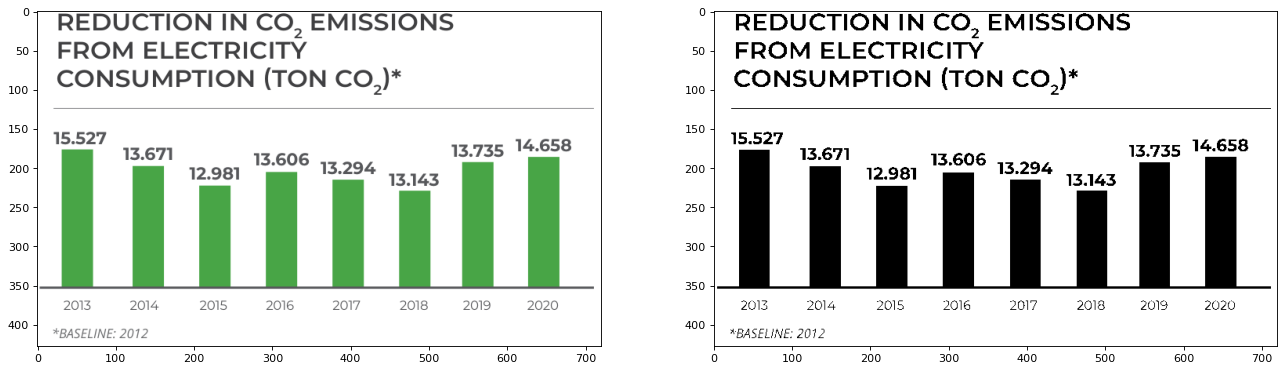

In [4]:
# eliminate noise
def img_preprocessing(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    norm_img = np.zeros((image.shape[0], image.shape[1]))
    image = cv2.normalize(image, norm_img, 0, 255, cv2.NORM_MINMAX)
    image = cv2.threshold(image, 120, 255, cv2.THRESH_BINARY)[1]  # > threshold 120, set it to maxval 255 white, otherwise 0 black
    image = cv2.GaussianBlur(image, (1, 1), 0)  # Gaussian Smoothing
    return image


# using PIL show image
def Image_show(original_img, image):
    img_cvt1 = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    img_cvt1 = Image.fromarray(img_cvt1)
    img_cvt2 = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_cvt2 = Image.fromarray(img_cvt2)

    figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8), dpi=80)
    ax[0].imshow(img_cvt1)
    ax[1].imshow(img_cvt2)


# using cv2 show image
# def show(name, img):
#     cv2.imshow(name, img)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
#     cv2.waitKey(1)
# show('image', img)

# original_img = cv2.imread('bar_chart.png')
original_img = cv2.imread(filename)

img = img_preprocessing(original_img)
Image_show(original_img, img)

### Extracting coordinate system info

Using pytesseract libray to extract text

In [5]:
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
data = pytesseract.image_to_data(img_rgb)

# convert to dataframe and delete nan values and blank spaces
df = pd.read_csv(StringIO(data), sep='\t')
df = df.dropna().reset_index().drop(labels='index', axis=1)
df = df[~df['text'].isin([' ','  ','   '])]
df

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,5,1,1,1,1,1,28,4,194,22,96.511169,REDUCTION
1,5,1,1,1,1,2,237,5,30,21,95.972939,IN
2,5,1,1,1,1,3,280,4,58,32,95.473602,"CO,"
3,5,1,1,1,1,4,351,4,180,22,95.961945,EMISSIONS
4,5,1,1,1,2,1,28,40,94,22,96.591255,FROM
5,5,1,1,1,2,2,137,40,207,22,95.471336,ELECTRICITY
6,5,1,1,1,3,1,26,76,250,22,95.940277,CONSUMPTION
7,5,1,1,1,3,2,291,73,77,29,92.454483,(TON
8,5,1,1,1,3,3,381,73,83,35,78.069229,"CO,)*"
10,5,1,3,1,1,1,22,155,66,16,96.230003,15.527


In [22]:
# title lies on the top-most of the chart in most cases
# title = df[df.top == df.top.min()].text.values
title = df[df.top == sorted(set(df.top.values))[2]].text.values
title = ' '.join(title)
ic(title)


# y label lies on the left-most of the chart in most cases, adjacent to y-axis
y_label = df[df.left == df.left.min()].text.values
y_label = ' '.join(y_label)

set_point = sorted(set(df.left.values))[2]
error_tol1 = set_point - 1  # Error tolerance
error_tol2 = set_point + 1
# y_axis = df[df.left == set_point].text.values
y_df = df[df.left.isin([set_point,error_tol1,error_tol2])]
y_axis = y_df.text.values
# y_axis = list(map(lambda x: int(x), y_axis))  # str -> int 
y_top_pixel = y_df.top.values
y_h_pixel = y_df.height.values
ic(y_label, y_axis, y_top_pixel, y_h_pixel)  # 0 was not recognized

# x label lies on the bottom-most of the chart in most cases, adjacent to x-axis
x_label = df[df.top == df.top.max()].text.values
x_label = ' '.join(x_label)

x_df = df[df.top == sorted(set(df.top.values))[-2]]
x_axis = x_df.text.values
x_left_pixel = x_df.left.values 
x_w_pixel = x_df.width.values 
ic(x_label, x_axis, x_left_pixel, x_w_pixel)

ic| title: 'Number of police officers Crimeville,'
ic| y_label: 'Number of police officers'
    y_axis: array(['60', '50', '40', '30', '20', '10'], dtype=object)
    y_top_pixel: array([ 88, 149, 210, 271, 332, 393])
    y_h_pixel: array([9, 9, 9, 9, 9, 9])
ic| x_label: 'Year'
    x_axis: array(['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
                   '2019'], dtype=object)
    x_left_pixel: array([122, 200, 279, 357, 436, 514, 592, 671, 749])
    x_w_pixel: array([30, 30, 30, 30, 30, 30, 30, 30, 30])


('Year',
 array(['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
        '2019'], dtype=object),
 array([122, 200, 279, 357, 436, 514, 592, 671, 749]),
 array([30, 30, 30, 30, 30, 30, 30, 30, 30]))

find real x and y piexel value

x_real_pixel = x_left_pixel + x_w_pixel / 2

y_real_pixel = y_top_pixel + y_h_pixel / 2

In [23]:
x_real_pixel = x_left_pixel + x_w_pixel / 2
y_real_pixel = y_top_pixel + y_h_pixel / 2
ic(x_real_pixel, y_real_pixel)

ic| x_real_pixel: array([137., 215., 294., 372., 451., 529., 607., 686., 764.])
    y_real_pixel: array([ 92.5, 153.5, 214.5, 275.5, 336.5, 397.5])


(array([137., 215., 294., 372., 451., 529., 607., 686., 764.]),
 array([ 92.5, 153.5, 214.5, 275.5, 336.5, 397.5]))

In [24]:
# 0 was not recognized, so calculate it according to other value
y_axis = y_axis.tolist()
y_axis.append('0')

diff = []
for i in range(1, len(y_real_pixel)):
    dif = int(y_real_pixel[i]) - int(y_real_pixel[i-1])
    diff.append(dif)

ic(diff)  # if not same, get the mode value or median or mean
y_pixel_max = y_real_pixel[-1] + diff[0]
y_real_pixel = y_real_pixel.tolist()
y_real_pixel.append(y_pixel_max)

ic(y_axis, y_real_pixel, y_pixel_max)

ic| diff: [61, 61, 61, 61, 61]
ic| y_axis: ['60', '50', '40', '30', '20', '10', '0']
    y_real_pixel: [92.5, 153.5, 214.5, 275.5, 336.5, 397.5, 458.5]
    y_pixel_max: 458.5


(['60', '50', '40', '30', '20', '10', '0'],
 [92.5, 153.5, 214.5, 275.5, 336.5, 397.5, 458.5],
 458.5)

### Canny Edge Detection

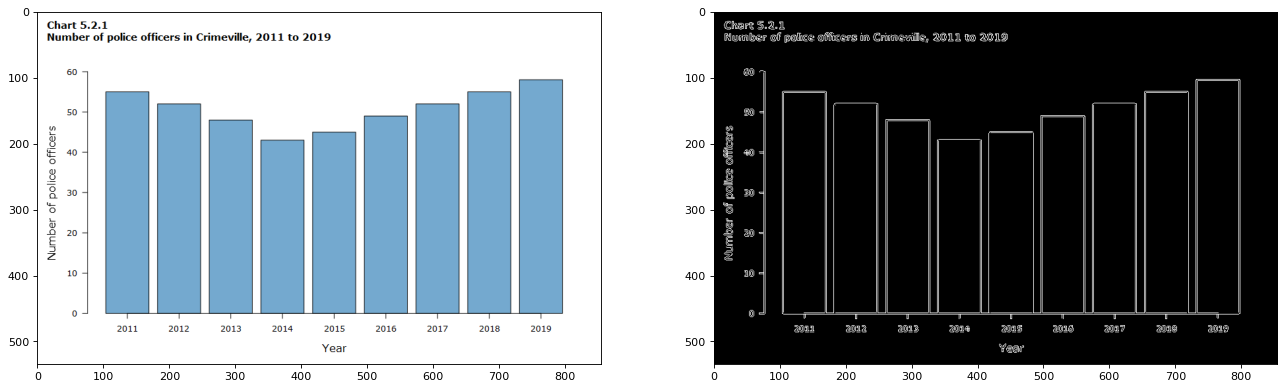

In [25]:
gray= cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
edges= cv2.Canny(gray, 50, 200)
# _, edges = cv2.threshold(gray, 150, 200, cv2.THRESH_BINARY)  # apply binary thresholding
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

Image_show(original_img, edges)

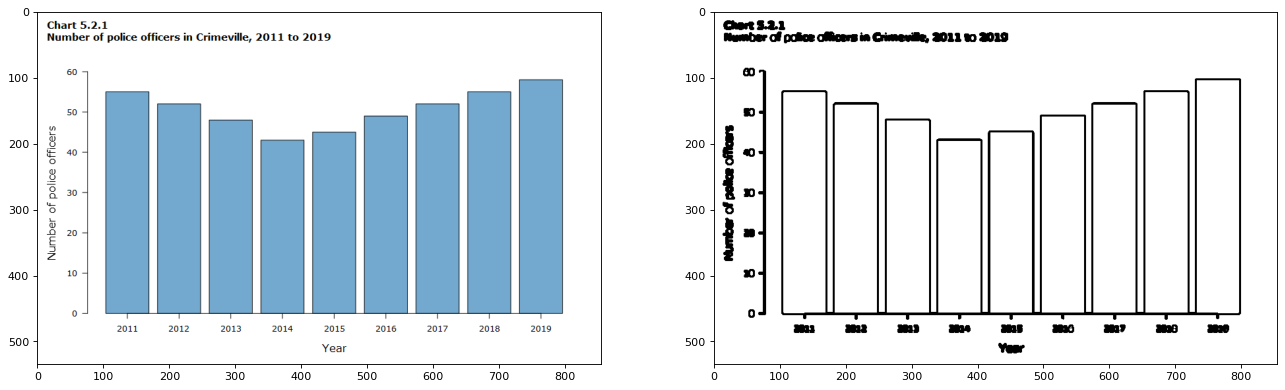

In [26]:
# draw the contours
tmp = cv2.drawContours(img, contours, -1, (0,0,255), 2)  
Image_show(original_img, tmp)

### Calculate real y-axis value based on proportion

In [27]:
# x correspond to y pixel value
y_dic = defaultdict(list)
for i in contours:
    for j in i:
        if j[0][0] in x_real_pixel and y_real_pixel[0] <= j[0][1] <= y_real_pixel[-1]:
            y_dic[j[0][0]].append(j[0][1])

x_y_value = sorted(y_dic.items(), key=lambda x:x[0])
x_y_value

[(137, [121]),
 (215, [139]),
 (294, [164]),
 (372, [194]),
 (451, [182]),
 (529, [158]),
 (607, [139]),
 (686, [121]),
 (764, [103])]

In [28]:
# img_w, img_l = original_img.shape[0], original_img.shape[1]
y_pixel_min = y_real_pixel[0]
y_axis_max = int(y_axis[0])
ic(y_pixel_min, y_axis_max)

ic| y_pixel_min: 92.5, y_axis_max: 60


(92.5, 60)

y = (y_pixel_max - x_y_value) / (y_pixel_max - y_pixel_min) * y_axis_max


In [30]:
y_axis_value = []
for i in x_y_value:
    y = (y_pixel_max - i[1][0]) / (y_pixel_max - y_pixel_min) * y_axis_max
    y = round(y, 2)
    y_axis_value.append(y)
y_axis_value

[55.33, 52.38, 48.28, 43.36, 45.33, 49.26, 52.38, 55.33, 58.28]

In [31]:
# data = pd.DataFrame(y_label:y_axis_value, columns=x_axis)
data = pd.DataFrame(index=range(1), columns=x_axis)
data.iloc[0:] = y_axis_value
data

,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,55.33,52.38,48.28,43.36,45.33,49.26,52.38,55.33,58.28
